In [1]:
%matplotlib inline
import sys, os
from pathlib import Path

# for reading mat files
import scipy.io
import h5py

# array computations
import numpy as np
import xarray as xr
import scipy.stats

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# BIOQIC phantom MRE data

In [2]:
def print_mat_info(d, level=0, tab=' '*4):
    for k, v in d.items():
        if hasattr(v, 'shape'):
            print(tab*level + f'{k}: {type(v)} {v.shape} {v.dtype}')
        else:
            print(tab*level + f'{k}: {type(v)}')
        if hasattr(v, 'items'):
            print_mat_info(v, level+1)

def load_mat_data(mat_file, verbose=True):
    try:
        data = scipy.io.loadmat(mat_file)
    except NotImplementedError as e:
        # Please use HDF reader for matlab v7.3 files
        data = h5py.File(mat_file)
    if verbose:
        print_mat_info(data)
    return data

repo_dir = Path('/ocean/projects/asc170022p/mtragoza/mre-siren')
data_dir = repo_dir / 'data' / 'BIOQIC'
os.chdir(data_dir)
%ls

phantom_raw.mat          phantom_unwrapped.mat
phantom_raw_complex.mat  phantom_unwrapped_dejittered.mat


In [3]:
data_raw = load_mat_data('phantom_raw.mat')

#refs#: <class 'h5py._hl.group.Group'>
    #a#: <class 'h5py._hl.dataset.Dataset'> (24, 1) uint16
    #b#: <class 'h5py._hl.dataset.Dataset'> (27, 1) uint16
    #c#: <class 'h5py._hl.dataset.Dataset'> (26, 1) uint16
    #d#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
    #e#: <class 'h5py._hl.dataset.Dataset'> (39, 1) uint16
    #f#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
info: <class 'h5py._hl.group.Group'>
    dx_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dy_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dz_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    frequencies_Hz: <class 'h5py._hl.dataset.Dataset'> (8, 1) float64
    index_description: <class 'h5py._hl.dataset.Dataset'> (1, 6) object
    size: <class 'h5py._hl.dataset.Dataset'> (6, 1) float64
magnitude: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64
phase: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64


In [4]:
data_unw = load_mat_data('phantom_unwrapped.mat')

#refs#: <class 'h5py._hl.group.Group'>
    #a#: <class 'h5py._hl.dataset.Dataset'> (24, 1) uint16
    #b#: <class 'h5py._hl.dataset.Dataset'> (27, 1) uint16
    #c#: <class 'h5py._hl.dataset.Dataset'> (26, 1) uint16
    #d#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
    #e#: <class 'h5py._hl.dataset.Dataset'> (39, 1) uint16
    #f#: <class 'h5py._hl.dataset.Dataset'> (15, 1) uint16
info: <class 'h5py._hl.group.Group'>
    dx_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dy_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    dz_m: <class 'h5py._hl.dataset.Dataset'> (1, 1) float64
    frequencies_Hz: <class 'h5py._hl.dataset.Dataset'> (8, 1) float64
    index_description: <class 'h5py._hl.dataset.Dataset'> (1, 6) object
    size: <class 'h5py._hl.dataset.Dataset'> (6, 1) float64
magnitude: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64
phase_unwrapped: <class 'h5py._hl.dataset.Dataset'> (8, 3, 8, 25, 128, 80) float64


In [5]:
data_dej = load_mat_data('phantom_unwrapped_dejittered.mat')

__header__: <class 'bytes'>
__version__: <class 'str'>
__globals__: <class 'list'>
info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64


In [6]:
data_com = load_mat_data('phantom_raw_complex.mat')

__header__: <class 'bytes'>
__version__: <class 'str'>
__globals__: <class 'list'>
cube: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) complex128
voxelsizem: <class 'numpy.ndarray'> (1, 3) float64
frequenciesHz: <class 'numpy.ndarray'> (1, 8) uint8


# Convert phantom data to xarray dataset

In [7]:
%%time

# metadata from pdf doc applies to all data
metadata = dict(
    dims=['freq', 'MEG', 't', 'z', 'x', 'y'],
    coords=dict(
        freq=[30, 40, 50, 60, 70, 80, 90, 100],
        MEG=['y', 'x', 'z']
    )
)

# create xarray dataset from downloaded files
ds = xr.Dataset(dict(
    magni_raw = xr.DataArray(data_raw['magnitude'], **metadata),
    phase_raw = xr.DataArray(data_raw['phase'], **metadata),
    magni_unwrap = xr.DataArray(data_unw['magnitude'], **metadata),
    phase_unwrap = xr.DataArray(data_unw['phase_unwrapped'], **metadata),
    magni_dejit = xr.DataArray(data_dej['magnitude'].transpose(range(6)[::-1]).astype(np.float64), **metadata),
    phase_dejit = xr.DataArray(data_dej['phase_unwrap_noipd'].transpose(range(6)[::-1]), **metadata),
    cube_real = xr.DataArray(data_com['cube'].real.transpose(range(6)[::-1]), **metadata),
    cube_imag = xr.DataArray(data_com['cube'].imag.transpose(range(6)[::-1]), **metadata)
))
ds

CPU times: user 5.86 s, sys: 717 ms, total: 6.58 s
Wall time: 12.2 s


<xarray.Dataset>
Dimensions:       (freq: 8, MEG: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * freq          (freq) int64 30 40 50 60 70 80 90 100
  * MEG           (MEG) <U1 'y' 'x' 'z'
Dimensions without coordinates: t, z, x, y
Data variables:
    magni_raw     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_raw     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 1.364 2.938
    magni_unwrap  (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_unwrap  (freq, MEG, t, z, x, y) float64 4.695e-09 ... -3.346
    magni_dejit   (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_dejit   (freq, MEG, t, z, x, y) float64 -0.6366 -1.153 ... -3.561
    cube_real     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 8.43 -76.38
    cube_imag     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 40.12 15.8

In [8]:
# descriptive statistics
ds.to_dataframe().describe().transpose()

count        mean         std          min         25%  \
magni_raw     49152000.0  313.954245  233.221729     0.000000   59.000000   
phase_raw     49152000.0   -0.044564    1.586261    -3.141593   -1.199573   
magni_unwrap  49152000.0  313.954245  233.221729     0.000000   59.000000   
phase_unwrap  49152000.0    0.930254   13.145816  -382.237333   -1.587671   
magni_dejit   49152000.0  313.954245  233.221729     0.000000   59.000000   
phase_dejit   49152000.0    0.930749   10.594018  -293.254524   -1.548938   
cube_real     49152000.0   96.242596  270.731862 -2297.871142  -33.276906   
cube_imag     49152000.0  -14.195944  264.952338 -2729.929769 -128.081800   

                     50%         75%          max  
magni_raw     425.000000  522.000000  2796.000000  
phase_raw      -0.069029    1.107534     3.141593  
magni_unwrap  425.000000  522.000000  2796.000000  
phase_unwrap    0.194816    3.152331   394.452422  
magni_dejit   425.000000  522.000000  2796.000000  
phase_dejit     0.181480    2.932810   302.263166  
cube_real      32.139456  327.953198  2686.298212  
cube_imag      -3.900401   79.083353  2302.279826

In [9]:
# TODO write out xarray dataset

# Visualize the phantom data

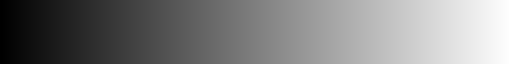

In [10]:
# create magnitude color map
magni_colors = [(0,0,0), (1,1,1)]
magni_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='magnitude', colors=magni_colors, N=255
)
magni_cmap

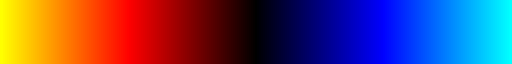

In [11]:
# create phase color map
phase_colors = [(1,1,0), (1,0,0), (0,0,0), (0,0,1), (0,1,1)]
phase_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='phase', colors=phase_colors, N=255
)
phase_cmap

In [12]:
def rgb_to_phase(rgb):
    assert rgb.shape[-1] == 3
    assert ((0 <= rgb) & (rgb <= 1)).all()
    r = rgb[...,0]
    g = rgb[...,1]
    b = rgb[...,2]
    y = np.where(r == 1, g, 0)
    c = np.where(b == 1, g, 0)
    return (y + r - b - c)/2
    
rgb_to_phase(np.array([
    [1, 1, 0],
    [1, 0, 0],
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 1],
    [1, 1, 1]
]))

array([ 1. ,  0.5,  0. , -0.5, -1. ,  0. ])

In [127]:
def plot_mre_data(data, cmap, vmin, vmax, align_phase=False):

    # recreate the sample image
    n_rows = 8
    n_cols = 6
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(2.5*n_cols, 2.5*n_rows),
        gridspec_kw=dict(
            width_ratios=[7,1]*(n_cols//2),
            wspace=0.2,
            hspace=0.2
        )
    )
    for i in range(n_rows):
        for j in range(n_cols):

            ax = axes[i,j]
            im = np.array(data[i,j//2,0,0,:,:].T)

            # estimate the phase shift
    
            # attempt 1: mean centering
            #phase_shift = int(np.round(im.mean() / (2*np.pi)))
            #im -= phase_shift * 2 *np.pi

            # attempt 2: too many outliers, use median
            phase_shift = np.round(np.median(im) / (2*np.pi))
                
            if align_phase: 
                im -= int(phase_shift) * 2*np.pi

                # two potential issues:
                # 1) is this robust?
                # 2) is this differentiable? does it need to be?
                
            phase_shift2 = np.round(np.median(im) / (2*np.pi))

            if j%2 == 0: # show image slice
                ax.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)
                ax.set_xticks([])
                ax.set_yticks([])
                xlabel = f'{phase_shift:.2f}, {phase_shift2:.2f}'
        
            else: # box plot of image values
                ax.boxplot(x=im.flatten(), widths=0.5, sym='')
                xlabel = f''
                ax.spines['bottom'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                ax.set_xticks([])

            if j == 0:
                ax.set_ylabel(f'{data.coords["freq"][i].values} Hz')
            if i == 7:
                xlabel += '\n' + str(data.coords['MEG'][j//2].values)
            ax.set_xlabel(xlabel)

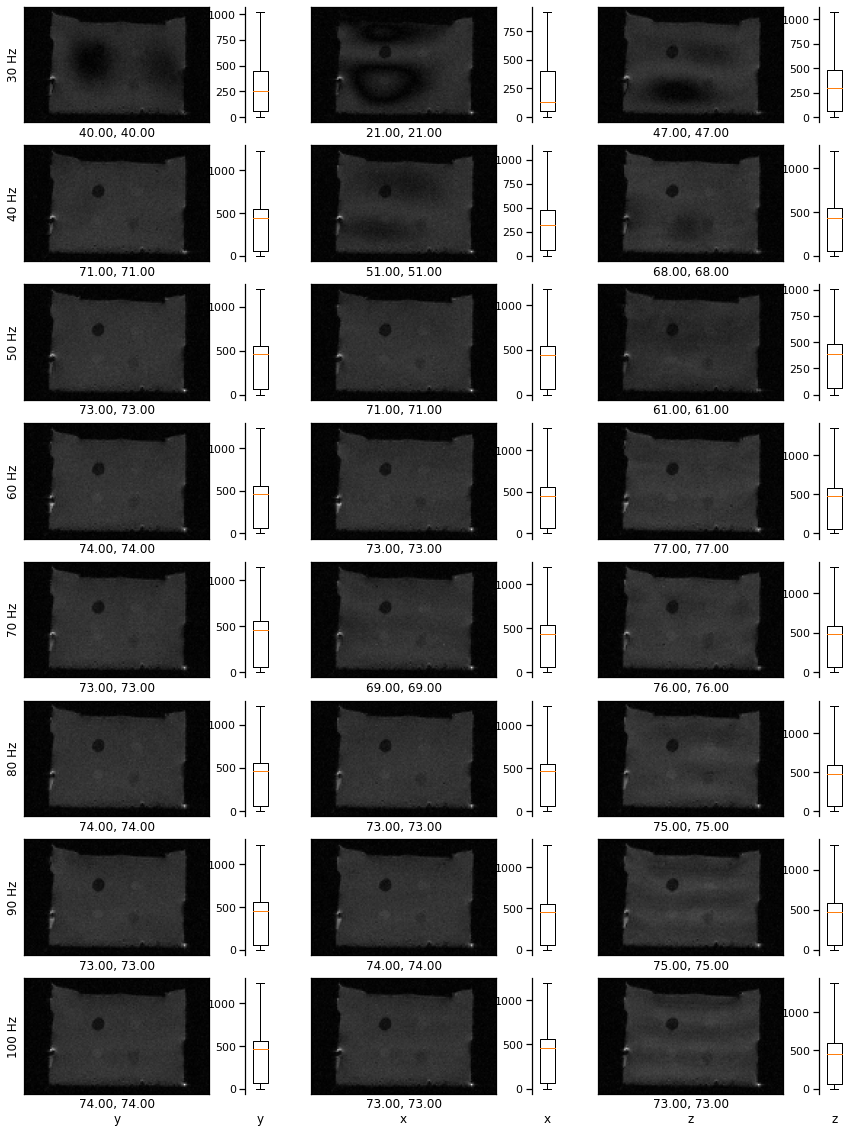

In [16]:
plot_mre_data(ds['magni_raw'], cmap=magni_cmap, vmin=0, vmax=2796)

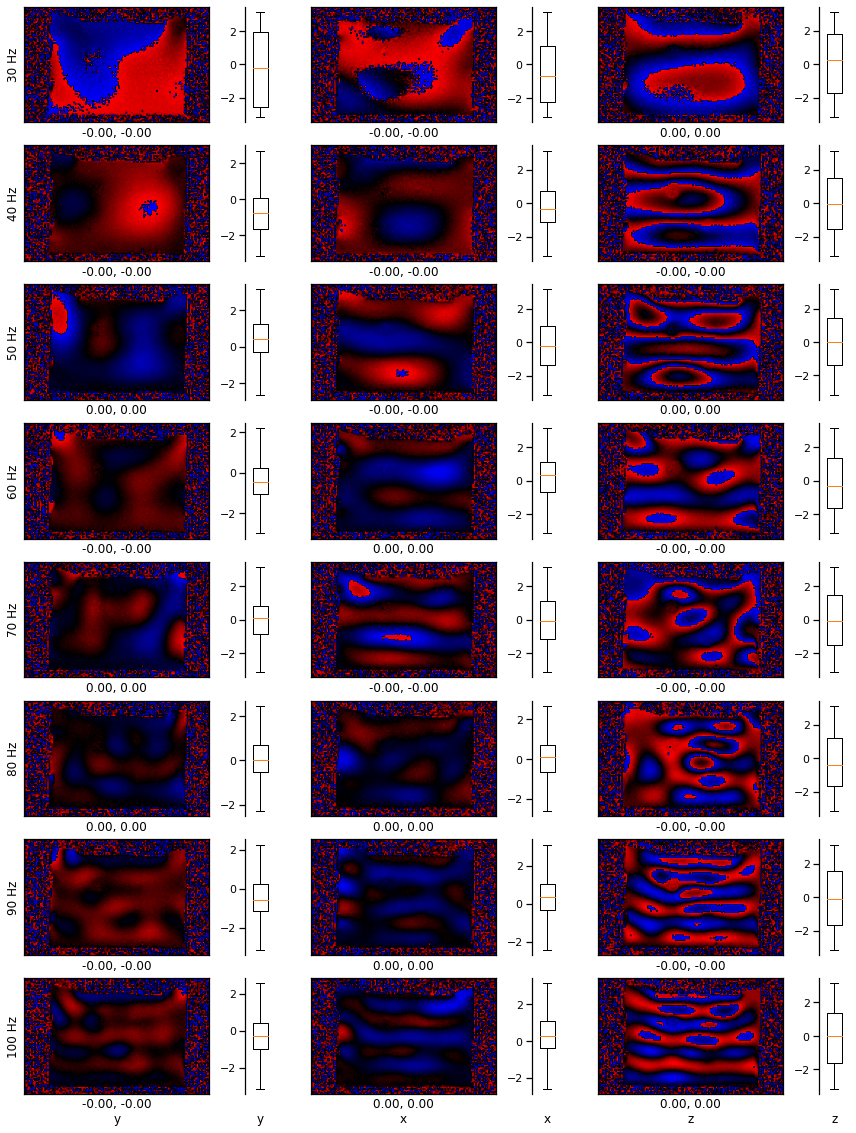

In [17]:
plot_mre_data(ds['phase_raw'], cmap=phase_cmap, vmin=-2*np.pi, vmax=2*np.pi)

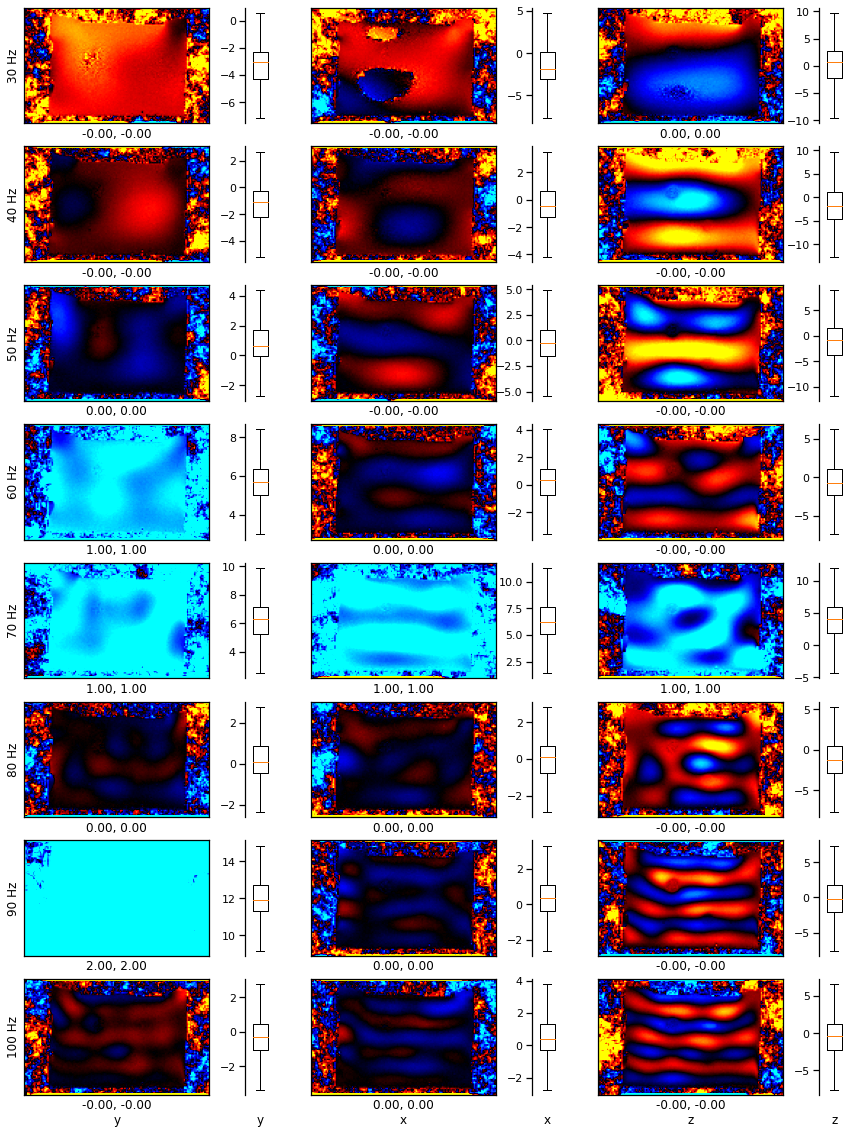

In [26]:
plot_mre_data(ds['phase_unwrap'], cmap=phase_cmap, vmin=-2*np.pi, vmax=2*np.pi)

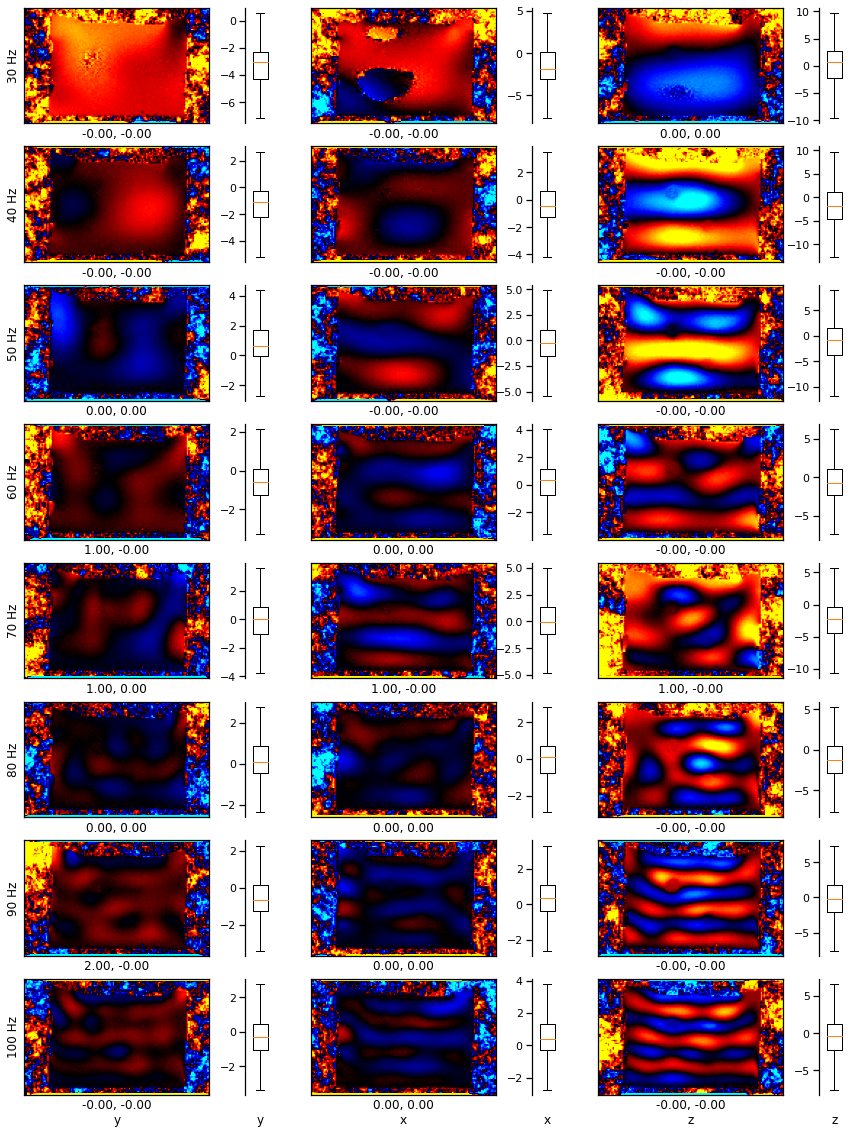

In [28]:
plot_mre_data(ds['phase_unwrap'], cmap=phase_cmap, vmin=-2*np.pi, vmax=2*np.pi, align_phase=True)

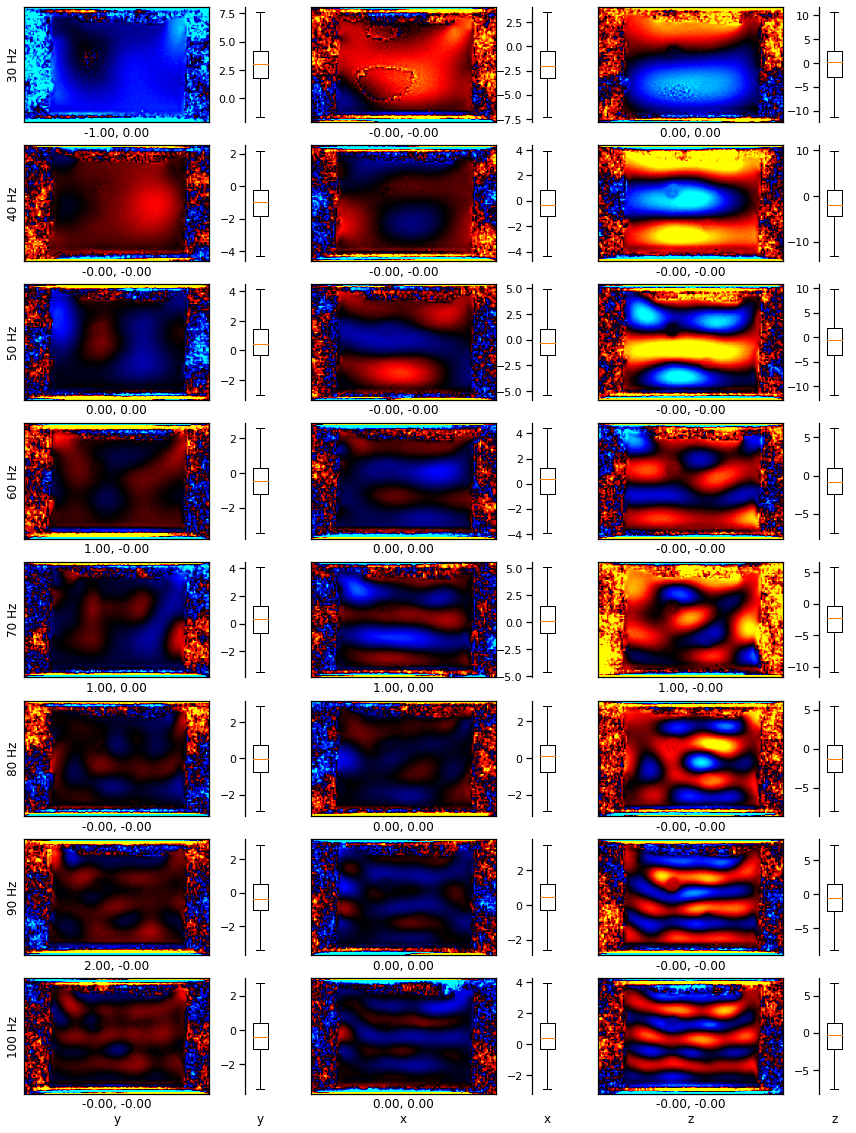

In [32]:
plot_mre_data(ds['phase_dejit'], cmap=phase_cmap, vmin=-2*np.pi, vmax=2*np.pi, align_phase=True)

# Phase data preprocessing

In [94]:
ds

<xarray.Dataset>
Dimensions:       (freq: 8, MEG: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * freq          (freq) int64 30 40 50 60 70 80 90 100
  * MEG           (MEG) <U1 'y' 'x' 'z'
Dimensions without coordinates: t, z, x, y
Data variables:
    magni_raw     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_raw     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 1.364 2.938
    magni_unwrap  (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_unwrap  (freq, MEG, t, z, x, y) float64 4.695e-09 ... -3.346
    magni_dejit   (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 67.0 41.0 78.0
    phase_dejit   (freq, MEG, t, z, x, y) float64 -0.6366 -1.153 ... -3.561
    cube_real     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 8.43 -76.38
    cube_imag     (freq, MEG, t, z, x, y) float64 0.0 0.0 0.0 ... 40.12 15.8

In [95]:
def phase_to_complex(phase):
    '''
    Convert phase to complex value.
    This is the inverse of np.angle,
    up to an integer multiple of 2 pi.
    '''
    return np.exp(1j*phase)

A = np.random.randn(1000)
np.linalg.norm(np.angle(phase_to_complex(A)) - A, np.inf)

6.283185307179586

In [139]:
def smooth_phase(phase, as_complex=True, sigma=0.65):
    from scipy.ndimage import gaussian_filter
    
    n_freq = phase.shape[0]
    n_MEG = phase.shape[1]
    n_t = phase.shape[2]
    n_z = phase.shape[3]
    
    smoothed_phase = phase.copy()
    
    # iterate over 3D volumes
    for f in range(n_freq):
        for m in range(n_MEG):
            for t in range(n_t):

                p = phase[f,m,t]
                if as_complex:   
                    p = phase_to_complex(p)
                    p = gaussian_filter(p, sigma=sigma, truncate=3)
                    p = np.angle(p)
                else:
                    p = gaussian_filter(p, sigma=sigma, truncate=3)
                smoothed_phase[f,m,t] = p
    
    return smoothed_phase

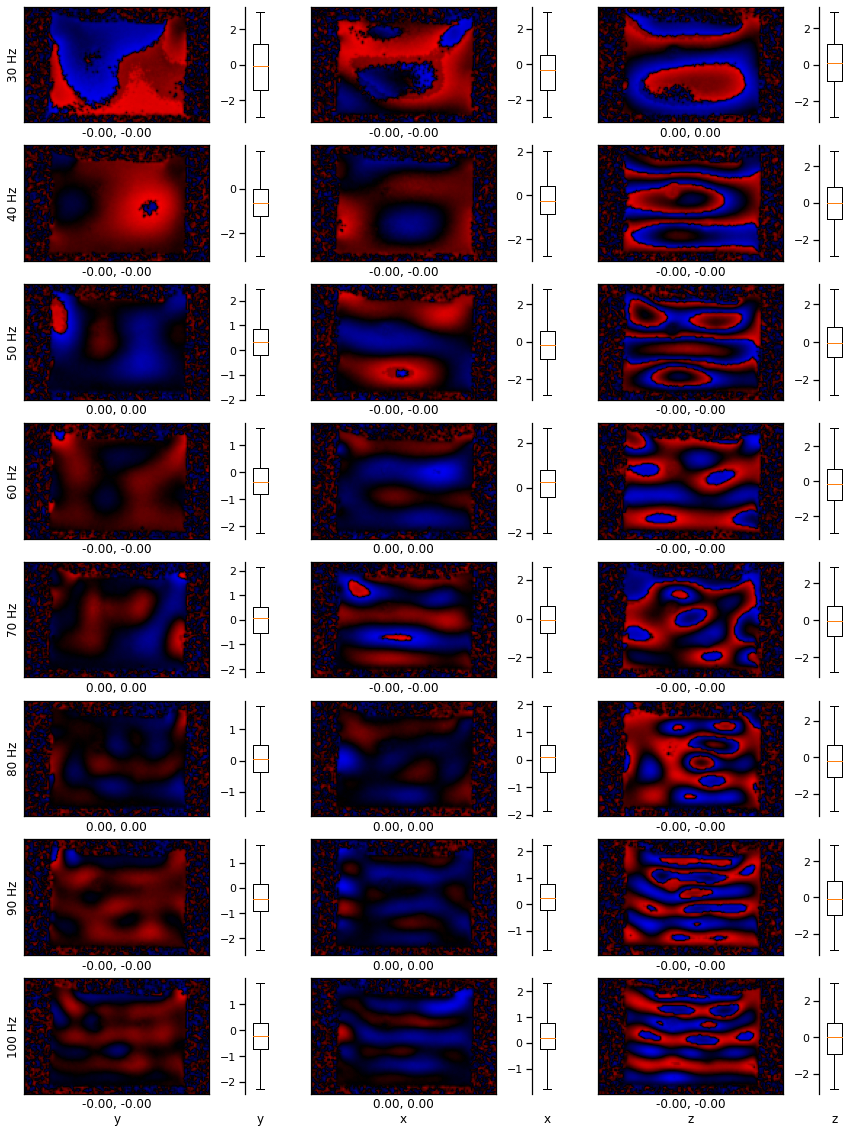

In [155]:
plot_mre_data(
    data=smooth_phase(ds['phase_raw'], sigma=sigma, as_complex=False),
    cmap=phase_cmap, vmin=-2*np.pi, vmax=2*np.pi, align_phase=True
)

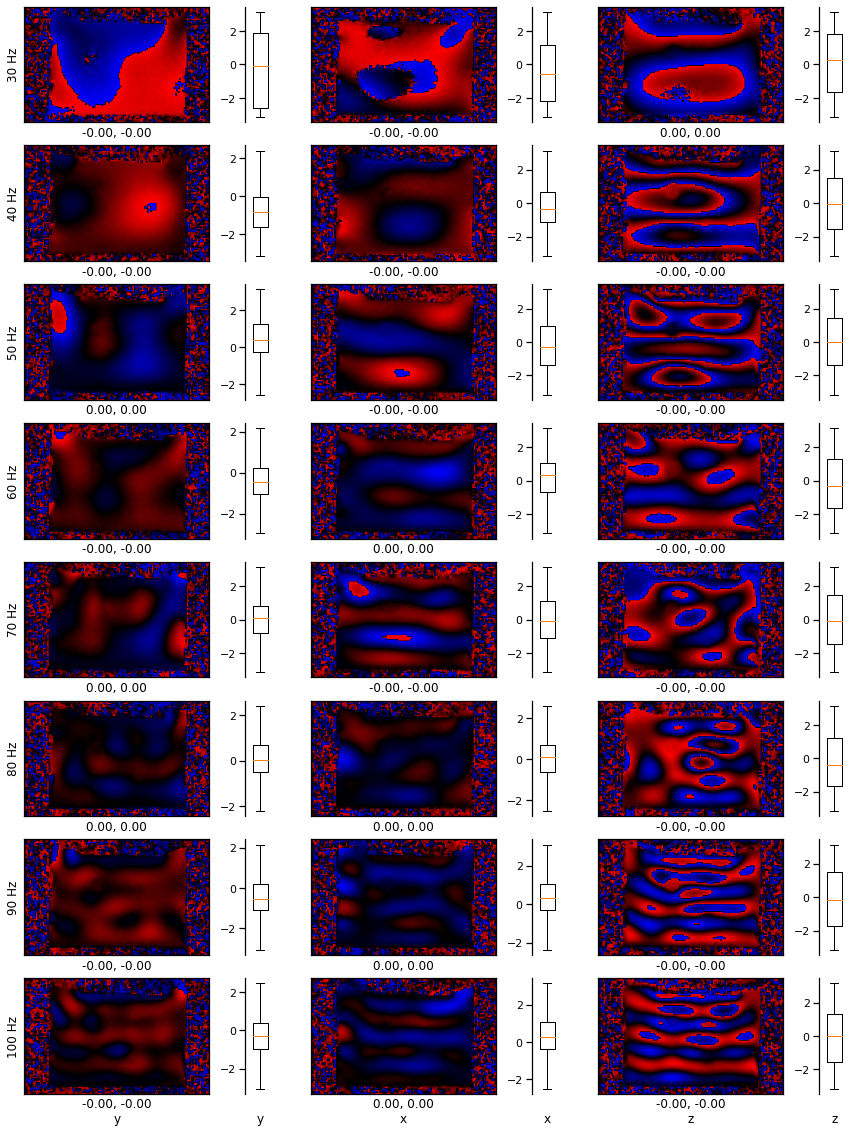

In [188]:
sigma = 0.65

phase_smooth = smooth_phase(ds['phase_raw'], sigma=sigma, as_complex=True)
plot_mre_data(
    data=phase_smooth,
    cmap=phase_cmap, vmin=-2*np.pi, vmax=2*np.pi, align_phase=True
)

In [189]:
def unwrap_phase(phase, resolution, n_harm=0):
    
    n_freq = phase.shape[0]
    n_MEG = phase.shape[1]
    n_t = phase.shape[2]
    n_z = phase.shape[3]
    n_x = phase.shape[4]
    n_y = phase.shape[5]
    
    wave_field = np.zeros((n_freq, n_MEG, 3, n_z, n_x, n_y))

    # iterate over 3D volumes
    for f in range(n_freq):
        for m in range(n_MEG):
            
            # get spatial gradients
            grad_z = np.zeros((n_t, n_z, n_x, n_y))
            grad_x = np.zeros((n_t, n_z, n_x, n_y))
            grad_y = np.zeros((n_t, n_z, n_x, n_y))
            
            for t in range(n_t):

                p = phase_to_complex(phase[f,m,t])
                
                g_z, g_x, g_y = np.gradient(p)
                g_z /= resolution
                g_x /= resolution
                g_y /= resolution
                
                # in-plane derivative components
                grad_z[t] = np.imag(g_z * p)
                grad_x[t] = np.imag(g_x * p)
                grad_y[t] = np.imag(g_y * p)
                
            # fourier transformation
            freq_z = np.fft.fftn(grad_z, axes=(0,))
            freq_x = np.fft.fftn(grad_x, axes=(0,))
            freq_y = np.fft.fftn(grad_y, axes=(0,))
            
            # harmonic selection
            wave_field[f,m,0] = freq_z[n_harm]
            wave_field[f,m,1] = freq_x[n_harm]
            wave_field[f,m,2] = freq_y[n_harm]
    
    return wave_field

In [203]:
sigma = 0.65

metadata = dict(
    dims=['freq', 'MEG', 't', 'z', 'x', 'y'],
    coords=dict(
        freq=[30, 40, 50, 60, 70, 80, 90, 100],
        MEG=['y', 'x', 'z']
    )
)

wave_field = unwrap_phase(phase_smooth, resolution=1, n_harm=0)
wave_field = xr.DataArray(wave_field, **metadata)

/tmp/ipykernel_58269/1542461058.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  wave_field[f,m,0] = freq_z[n_harm]
/tmp/ipykernel_58269/1542461058.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  wave_field[f,m,1] = freq_x[n_harm]
/tmp/ipykernel_58269/1542461058.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  wave_field[f,m,2] = freq_y[n_harm]


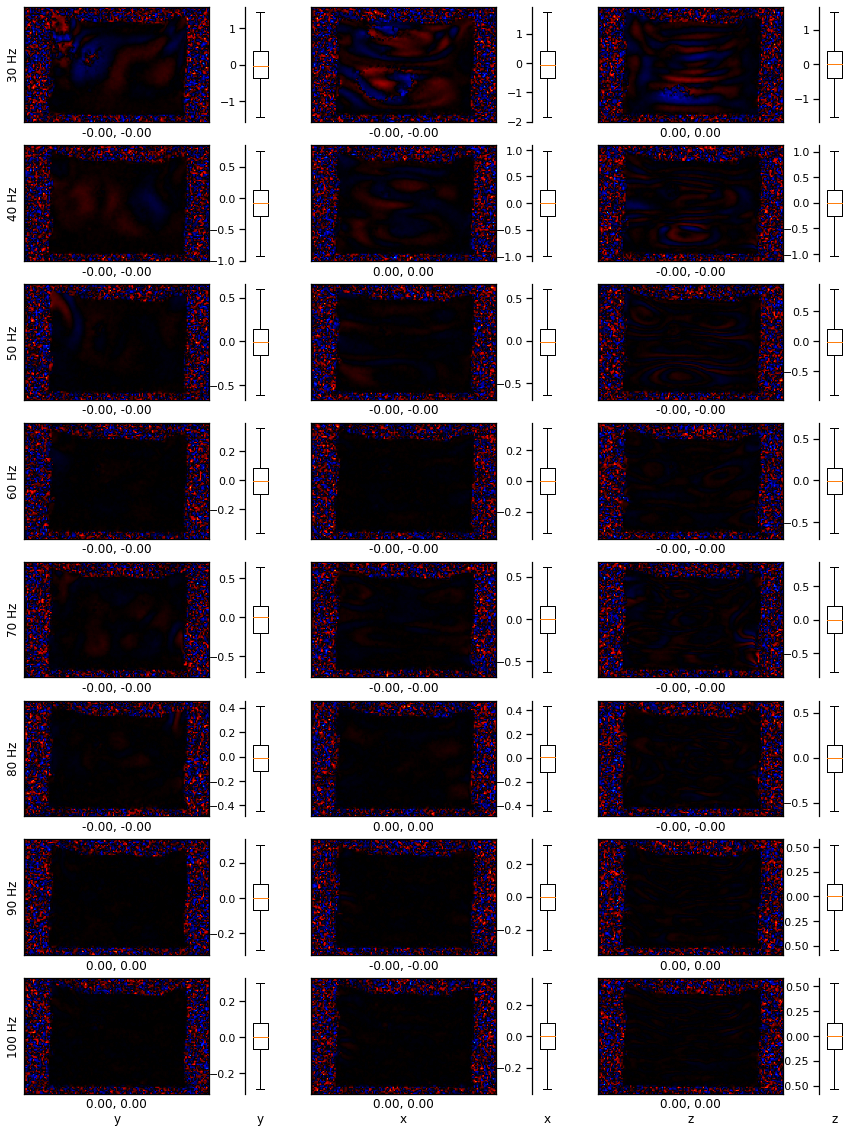

In [204]:
plot_mre_data(
    data=wave_field,
    cmap=phase_cmap, vmin=-2*np.pi, vmax=2*np.pi, align_phase=True
)